<a href="https://colab.research.google.com/github/DMSurya/CODSOFT/blob/main/face_detection_and_recognition(codsoft_task5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [7]:
def generate_image_pairs(images, labels):
    # Generate index for each label
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])

    # Generate image pairs and labels
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)

    return np.array(pair_images), np.array(pair_labels)

In [8]:
faces = '../input/olivetti/olivetti_faces.npy'
faces_targets = '../input/olivetti/olivetti_faces_target.npy'

In [9]:
!pip install scikit-learn
from sklearn.datasets import fetch_olivetti_faces

# Fetch the Olivetti faces dataset
faces = fetch_olivetti_faces()

# Access the images and labels
face_images = faces.images
face_labels = faces.target

In [10]:
target_shape = face_images[0].shape

In [11]:
images_dataset, labels_dataset = generate_image_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

In [12]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])

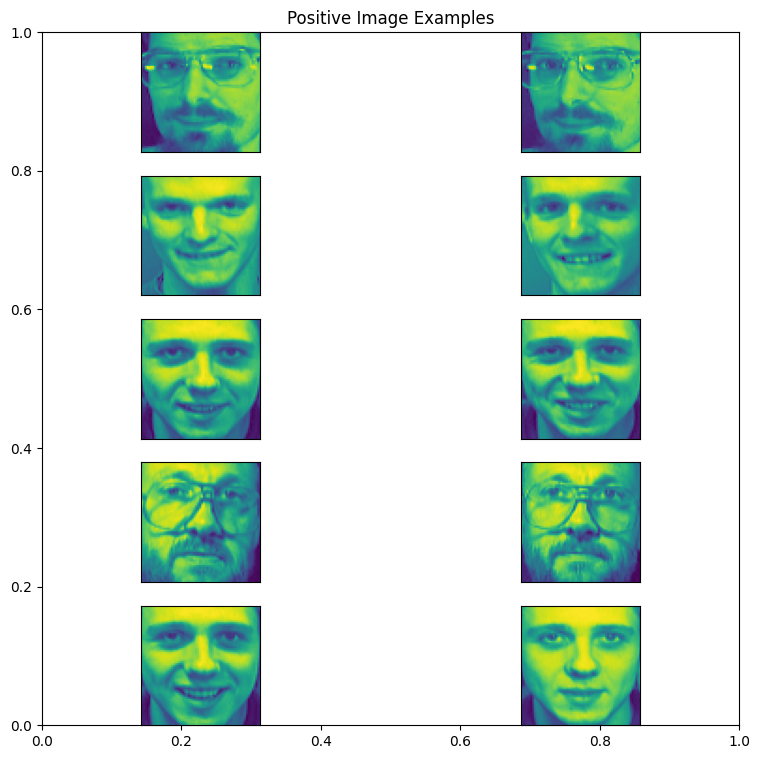

In [13]:
n = 5
indices = np.where(labels_dataset == 1)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Positive Image Examples")

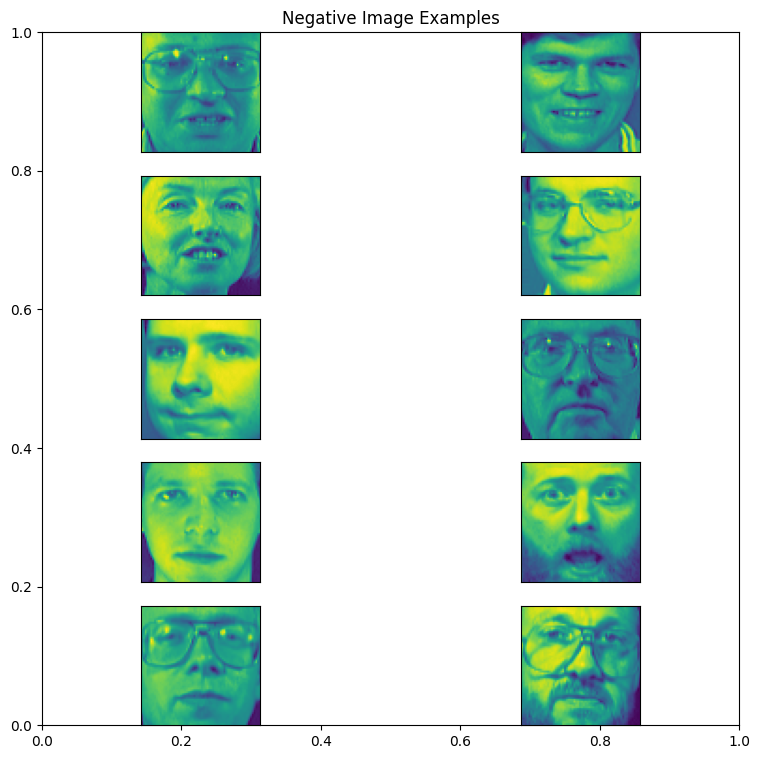

In [14]:
n = 5
indices = np.where(labels_dataset == 0)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Negative Image Examples")

In [15]:
inputs = layers.Input((64, 64, 1))

x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)
fcOutput = layers.Flatten()(x)
fcOutput = layers.Dense(4096, activation = "relu")(fcOutput)
outputs = layers.Dense(1024, activation = "sigmoid")(fcOutput)

embedding = Model(inputs, outputs, name = "Embedding")

In [16]:
import tensorflow.keras.backend as K

In [17]:
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss

In [18]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance
    between the embeddings
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [19]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

In [21]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset,
                            epochs=150, validation_split = 0.2, batch_size = 64)

Epoch 1/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 145s 14s/step - accuracy: 0.5284 - loss: 0.6935 - val_accuracy: 0.4437 - val_loss: 0.6935
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 142s 14s/step - accuracy: 0.4803 - loss: 0.6935 - val_accuracy: 0.4437 - val_loss: 0.6934
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 14s/step - accuracy: 0.4900 - loss: 0.6933 - val_accuracy: 0.4437 - val_loss: 0.6935
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 200s 14s/step - accuracy: 0.5308 - loss: 0.6930 - val_accuracy: 0.4437 - val_loss: 0.6938
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 137s 14s/step - accuracy: 0.5343 - loss: 0.6925 - val_accuracy: 0.4437 - val_loss: 0.6935
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 146s 14s/step - accuracy: 0.5226 - loss: 0.6925 - val_accuracy: 0.4437 - val_loss: 0.6936
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 138s 14s/step - accuracy: 0.5036 - loss: 0.6933 - val_accuracy: 0.4437 - val_loss: 0.6950
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 14s/step - accuracy: 0.5042 - loss: 0.6945 - val_accu

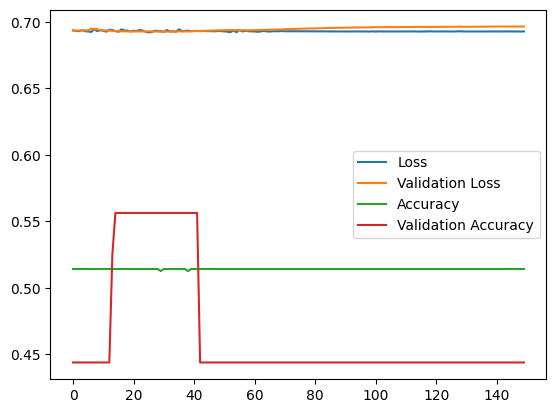

In [22]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])

In [23]:
def test_visualize(images, n = 5):
    """ Visualize a few images """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    axs = fig.subplots(1, n)
    for i in range(n):
        show(axs[i], images[i])

In [24]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

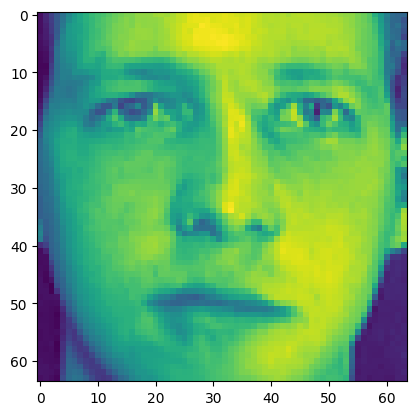

In [25]:
plt.imshow(test_image)

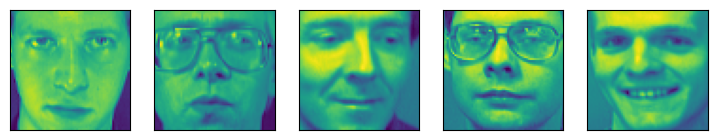

In [26]:
test_visualize(compare_images)

In [27]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))

image_pairs = np.array(image_pairs)

In [28]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


In [29]:
print(score)

[[0.51322377]
 [0.51322377]
 [0.51322377]
 [0.51322377]
 [0.51322377]]


In [30]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10, 20), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

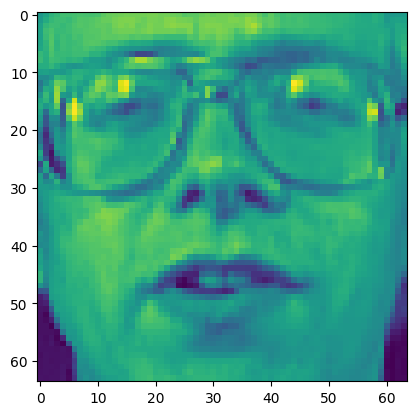

In [31]:
plt.imshow(test_image)

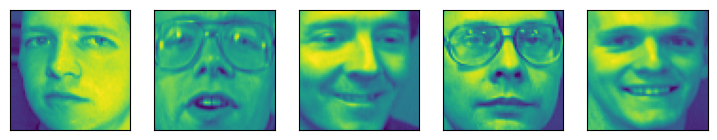

In [32]:
test_visualize(compare_images)

In [33]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))

image_pairs = np.array(image_pairs)

In [34]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])
print(score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
[[0.51322377]
 [0.51322377]
 [0.51322377]
 [0.51322377]
 [0.51322377]]
